In [2]:
import pandas as pd
from matplotlib import pyplot
from math import sqrt 
import numpy as np 
import scipy.misc 
import tensorflow as tf
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator 
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.optimizers import Adam, SGD
from keras.regularizers import l1, l2
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
%matplotlib inline

Using TensorFlow backend.


In [3]:
print(tf.__version__)

2.1.0


In [4]:
print(tf.test.is_gpu_available())
print(tf.test.is_built_with_cuda())

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
True
True


In [5]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4379767950448482269
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 12630488602863646621
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 945725468322147347
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 224722944
locality {
  bus_id: 1
  links {
  }
}
incarnation: 347620850863728126
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:1e.0, compute capability: 3.7"
]


In [6]:
#config = tf.compat.v1.ConfigProto()
#config.gpu_options.allow_growth = True
#sess = tf.compat.v1.Session(config=config)

In [7]:
data= pd.read_csv('FER - EMOTION/fer2013.csv')
data.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [8]:
data.emotion.value_counts()
#data.values.shape

3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64

In [9]:
data.Usage.value_counts() 

Training       28709
PublicTest      3589
PrivateTest     3589
Name: Usage, dtype: int64

In [10]:
emotion_labels = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]
classes=np.array(("Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"))

In [11]:
depth = 1
height = int(sqrt(len(data.pixels[0].split()))) 
width = int(height)
print(height,width)

48 48


In [12]:
'''
for i in range(0, 6): 
    array = np.mat(data.pixels[i]).reshape(height, width) 
    pyplot.imshow(X_batch[i].reshape(48, 48), cmap=pyplot.get_cmap('gray'))
    #image = array_to_img(array) 
    #display(image)
    #plt.imshow(image)
    #print(emotion_labels[data.emotion[i]])
'''

"\nfor i in range(0, 6): \n    array = np.mat(data.pixels[i]).reshape(height, width) \n    pyplot.imshow(X_batch[i].reshape(48, 48), cmap=pyplot.get_cmap('gray'))\n    #image = array_to_img(array) \n    #display(image)\n    #plt.imshow(image)\n    #print(emotion_labels[data.emotion[i]])\n"

In [13]:
train_set = data[(data.Usage == 'Training')] 
val_set = data[(data.Usage == 'PublicTest')]
test_set = data[(data.Usage == 'PrivateTest')] 
X_train = np.array(list(map(str.split, train_set.pixels)), np.float32) 
X_val = np.array(list(map(str.split, val_set.pixels)), np.float32) 
X_test = np.array(list(map(str.split, test_set.pixels)), np.float32) 
X_train = X_train.reshape(X_train.shape[0], 48, 48, 1) 
X_val = X_val.reshape(X_val.shape[0], 48, 48, 1)
X_test = X_test.reshape(X_test.shape[0], 48, 48, 1)

In [14]:
num_classes = 7
num_train = X_train.shape[0]
num_val = X_val.shape[0]
num_test = X_test.shape[0]

In [15]:
y_train = train_set.emotion
y_train = tf.keras.utils.to_categorical(y_train, num_classes) 
y_val = val_set.emotion 
y_val = tf.keras.utils.to_categorical(y_val, num_classes) 
y_test = test_set.emotion 
y_test = tf.keras.utils.to_categorical(y_test, num_classes) 

In [16]:
print(X_train.shape, X_val.shape)

(28709, 48, 48, 1) (3589, 48, 48, 1)


In [16]:
datagen = ImageDataGenerator( 
    rescale=1./255,
    rotation_range = 10,
    horizontal_flip = True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    fill_mode = 'nearest')

testgen = ImageDataGenerator( 
    rescale=1./255
    )
datagen.fit(X_train)
batch_size = 64

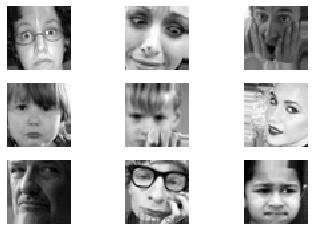

In [17]:
# For plotting purpose
for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size=9):
    for i in range(0, 9): 
        pyplot.axis('off') 
        pyplot.subplot(330 + 1 + i) 
        pyplot.imshow(X_batch[i].reshape(48, 48), cmap=pyplot.get_cmap('gray'))
    pyplot.axis('off') 
    pyplot.show() 
    break 

In [18]:
train_flow = datagen.flow(X_train, y_train, batch_size=batch_size) 
val_flow = testgen.flow(X_val, y_val, batch_size=batch_size) 
tes_flow = testgen.flow(X_test, y_test, batch_size=batch_size) 

In [19]:
#train_flow = tf.keras.preprocessing.image.NumpyArrayIterator(X_train, y_train, datagen,batch_size=batch_size)
#val_flow = tf.keras.preprocessing.image.NumpyArrayIterator(X_val, y_val, datagen, batch_size=batch_size) 
#tes_flow = tf.keras.preprocessing.image.NumpyArrayIterator(X_test, y_test, datagen, batch_size=batch_size) 

In [20]:
#print(type(train_flow))

In [21]:
print(X_train.shape)
print(y_train.shape)

(28709, 48, 48, 1)
(28709, 7)


In [22]:
len(X_train)

28709

In [23]:
def emo_Model(input_shape=(48,48,1)):
    # first input model
    visible = Input(shape=input_shape, name='input')
    num_classes = 7
    #the 1-st block
    conv1_1 = Conv2D(32, kernel_size=3, activation='relu', padding='same', name = 'conv1_1')(visible)
    conv1_2 = Conv2D(64, kernel_size=3, activation='relu', padding='same', name = 'conv1_2')(conv1_1)
    pool1_1 = MaxPooling2D(pool_size=(2,2), name = 'pool1_1')(conv1_2)
    drop1_1 = Dropout(0.25, name = 'drop1_1')(pool1_1)

    #the 2-nd block
    conv2_1 = Conv2D(128, kernel_size=3, activation='relu', padding='same', name = 'conv2_1')(drop1_1)
    pool2_1 = MaxPooling2D(pool_size=(2,2), name = 'pool2_1')(conv2_1)
    conv2_2 = Conv2D(128, kernel_size=3, activation='relu', padding='same', name = 'conv2_2')(pool2_1)
    pool2_2 = MaxPooling2D(pool_size=(2,2), name = 'pool2_2')(conv2_2)
    drop2_1 = Dropout(0.25, name = 'drop2_1')(pool2_2)

    #Flatten and output
    flatten = Flatten(name = 'flatten')(drop2_1)
    dense3_1 = Dense(1024, activation='relu', name='dense3_1')(flatten)
    drop3_1 = Dropout(0.5, name='drop3_1')(dense3_1)
    ouput = Dense(num_classes, activation='softmax', name = 'output')(drop3_1)

    # create model 
    model = Model(inputs =visible, outputs = ouput)
    # summary layers
    print(model.summary())
    
    return model

In [24]:
model = emo_Model()
opt = Adam(lr=0.0001, decay=1e-6)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy']) 
#plot_model(model, show_shapes=True)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 48, 48, 1)         0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 48, 48, 32)        320       
_________________________________________________________________
conv1_2 (Conv2D)             (None, 48, 48, 64)        18496     
_________________________________________________________________
pool1_1 (MaxPooling2D)       (None, 24, 24, 64)        0         
_________________________________________________________________
drop1_1 (Dropout)            (None, 24, 24, 64)        0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 24, 24, 128)       73856     
_________________________________________________________________
pool2_1 (MaxPooling2D)       (None, 12, 12, 128)       0   

In [25]:
from keras.callbacks import ModelCheckpoint
filepath="model1_weights_min_loss.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

In [26]:
len(X_val) // batch_size

56

In [27]:
print(tf.__version__)

2.1.0


In [28]:
num_epochs = 200 # we iterate 200 times over the entire training set 
history = model.fit(train_flow, 
                    steps_per_epoch=len(X_train) / batch_size, 
                    epochs=num_epochs,  
                    verbose=1,  
                    callbacks=callbacks_list,
                    validation_data=val_flow,  
                    validation_steps=len(X_val) / batch_size) 

Epoch 1/200
449/448 [==============================] - 24s 54ms/step - loss: 1.8051 - accuracy: 0.2532 - val_loss: 1.6572 - val_accuracy: 0.2948

Epoch 00001: val_loss improved from inf to 1.65722, saving model to model1_weights_min_loss.h5
Epoch 2/200
449/448 [==============================] - 20s 44ms/step - loss: 1.7145 - accuracy: 0.3123 - val_loss: 1.5779 - val_accuracy: 0.3901

Epoch 00002: val_loss improved from 1.65722 to 1.57790, saving model to model1_weights_min_loss.h5
Epoch 3/200
449/448 [==============================] - 20s 44ms/step - loss: 1.6386 - accuracy: 0.3554 - val_loss: 1.5410 - val_accuracy: 0.4296

Epoch 00003: val_loss improved from 1.57790 to 1.54102, saving model to model1_weights_min_loss.h5
Epoch 4/200
449/448 [==============================] - 20s 44ms/step - loss: 1.5784 - accuracy: 0.3886 - val_loss: 1.6747 - val_accuracy: 0.4505

Epoch 00004: val_loss did not improve from 1.54102
Epoch 5/200
449/448 [==============================] - 20s 43ms/step - l

449/448 [==============================] - 20s 44ms/step - loss: 1.0258 - accuracy: 0.6150 - val_loss: 1.3186 - val_accuracy: 0.6202

Epoch 00041: val_loss did not improve from 0.25591
Epoch 42/200
449/448 [==============================] - 20s 44ms/step - loss: 1.0227 - accuracy: 0.6158 - val_loss: 0.9672 - val_accuracy: 0.6177

Epoch 00042: val_loss did not improve from 0.25591
Epoch 43/200
449/448 [==============================] - 20s 44ms/step - loss: 1.0128 - accuracy: 0.6192 - val_loss: 1.6285 - val_accuracy: 0.6188

Epoch 00043: val_loss did not improve from 0.25591
Epoch 44/200
449/448 [==============================] - 20s 44ms/step - loss: 1.0070 - accuracy: 0.6224 - val_loss: 1.4896 - val_accuracy: 0.6208

Epoch 00044: val_loss did not improve from 0.25591
Epoch 45/200
449/448 [==============================] - 20s 44ms/step - loss: 1.0085 - accuracy: 0.6246 - val_loss: 0.7944 - val_accuracy: 0.6266

Epoch 00045: val_loss did not improve from 0.25591
Epoch 46/200
449/448 [=

449/448 [==============================] - 20s 44ms/step - loss: 0.7230 - accuracy: 0.7311 - val_loss: 0.6973 - val_accuracy: 0.6737

Epoch 00123: val_loss did not improve from 0.16312
Epoch 124/200
449/448 [==============================] - 20s 44ms/step - loss: 0.7265 - accuracy: 0.7334 - val_loss: 2.0164 - val_accuracy: 0.6701

Epoch 00124: val_loss did not improve from 0.16312
Epoch 125/200
449/448 [==============================] - 20s 44ms/step - loss: 0.7274 - accuracy: 0.7314 - val_loss: 0.2967 - val_accuracy: 0.6695

Epoch 00125: val_loss did not improve from 0.16312
Epoch 126/200
449/448 [==============================] - 20s 44ms/step - loss: 0.7145 - accuracy: 0.7372 - val_loss: 0.4361 - val_accuracy: 0.6732

Epoch 00126: val_loss did not improve from 0.16312
Epoch 127/200
449/448 [==============================] - 20s 44ms/step - loss: 0.7155 - accuracy: 0.7346 - val_loss: 0.3010 - val_accuracy: 0.6695

Epoch 00127: val_loss did not improve from 0.16312
Epoch 128/200
449/4

449/448 [==============================] - 20s 43ms/step - loss: 0.6324 - accuracy: 0.7649 - val_loss: 0.5813 - val_accuracy: 0.6779

Epoch 00164: val_loss did not improve from 0.05310
Epoch 165/200
449/448 [==============================] - 20s 44ms/step - loss: 0.6305 - accuracy: 0.7666 - val_loss: 0.3311 - val_accuracy: 0.6737

Epoch 00165: val_loss did not improve from 0.05310
Epoch 166/200
449/448 [==============================] - 20s 44ms/step - loss: 0.6216 - accuracy: 0.7713 - val_loss: 1.9118 - val_accuracy: 0.6754

Epoch 00166: val_loss did not improve from 0.05310
Epoch 167/200
449/448 [==============================] - 20s 43ms/step - loss: 0.6203 - accuracy: 0.7720 - val_loss: 0.5663 - val_accuracy: 0.6737

Epoch 00167: val_loss did not improve from 0.05310
Epoch 168/200
449/448 [==============================] - 20s 44ms/step - loss: 0.6236 - accuracy: 0.7709 - val_loss: 1.5767 - val_accuracy: 0.6723

Epoch 00168: val_loss did not improve from 0.05310
Epoch 169/200
449/4

In [29]:
history_dict = history.history
history_dict.keys()

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])

<Figure size 432x288 with 0 Axes>

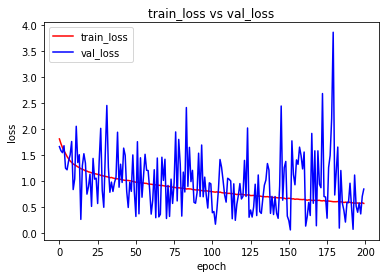

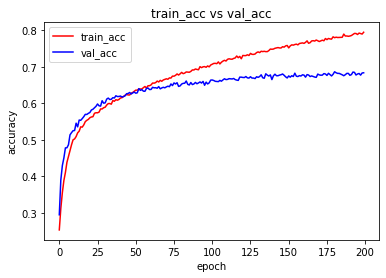

<Figure size 432x288 with 0 Axes>

In [30]:
%matplotlib inline

train_loss=history.history['loss']
val_loss=history.history['val_loss']
train_acc=history.history['accuracy']
val_acc=history.history['val_accuracy']

epochs = range(len(train_acc))

plt.plot(epochs,train_loss,'r', label='train_loss')
plt.plot(epochs,val_loss,'b', label='val_loss')
plt.title('train_loss vs val_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.figure()

plt.plot(epochs,train_acc,'r', label='train_acc')
plt.plot(epochs,val_acc,'b', label='val_acc')
plt.title('train_acc vs val_acc')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.figure()

In [31]:
model.save('emo_model_v1.h5') 

In [17]:
print(X_test.shape)

(3589, 48, 48, 1)


In [19]:
from tensorflow.keras.models import load_model

In [20]:
model = load_model('emo_model_v1.h5')
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 48, 48, 1)]       0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 48, 48, 32)        320       
_________________________________________________________________
conv1_2 (Conv2D)             (None, 48, 48, 64)        18496     
_________________________________________________________________
pool1_1 (MaxPooling2D)       (None, 24, 24, 64)        0         
_________________________________________________________________
drop1_1 (Dropout)            (None, 24, 24, 64)        0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 24, 24, 128)       73856     
_________________________________________________________________
pool2_1 (MaxPooling2D)       (None, 12, 12, 128)       0   

In [21]:
def plot_confusion_matrix(y_test, y_pred, classes,
                          normalize=False,
                          title='Unnormalized confusion matrix',
                          cmap=plt.cm.Blues):
    cm = confusion_matrix(y_test, y_pred)
    
    if normalize:
        cm = np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], 2)
        
    np.set_printoptions(precision=2)
        
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.min() + (cm.max() - cm.min()) / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True expression')
    plt.xlabel('Predicted expression')
    plt.show()


In [26]:
y_pred_ = model.predict(X_test/255., verbose=1)
y_pred = np.argmax(y_pred_, axis=1)
t_te = np.argmax(y_test, axis=1)

3589/3589 [==============================] - 1s 239us/sample


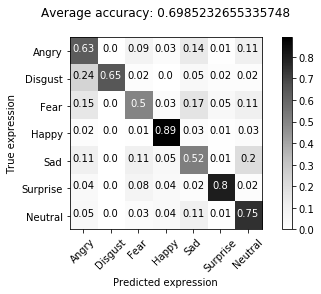

In [27]:
fig = plot_confusion_matrix(y_test=t_te, y_pred=y_pred,
                      classes=classes,
                      normalize=True,
                      cmap=plt.cm.Greys,
                      title='Average accuracy: ' + str(np.sum(y_pred == t_te)/len(t_te)) + '\n')